## Segmenting NBA Players with the K-Means Algorithm and PCA

I just finished my first semester of grad school at Georgia Tech, where I'm completing my MS in Data Analytics. I've been pretty eager for some free time to practice and apply the things I've learned on topics that I am passionate about. Naturally, I started with an NBA stats dataset. The data comes from https://www.basketball-reference.com, where I get almost all of my NBA data. To skip to the final results and vizualization, here is the link to the Tableau Workbork: https://public.tableau.com/views/NBAPlayerClusterAnalysis/ClusterDistributionsbyTeam?:embed=y&:display_count=yes.

In this analysis, I'm going to try to segment NBA players into talent buckets using the k-means clustering algorithm, which I'll explain later in the notebook. Before getting to the algorithm and the vizualization of those results, I have to do some data cleaning to get my dataset in the form it needs to be in.

Additionally, I'm going to tie in one of the more interesting topics I learned about this semester: Principal Component Analysis (PCA), which I'll also get to a little later in the notebook.

In [13]:
#importing all the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import svd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.cluster.vq import kmeans2


In [2]:
path = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\bballref1718.xlsx'

## Importing the Datasets
I'm bringing in both advanced stats and the usual per-game stats for the analysis. Here are the first 5 rows from each dataset:

In [3]:
advanced_stats = pd.read_excel(path,'Advanced')
pergame_stats = pd.read_excel(path, 'PerGame')

display(advanced_stats.head())

display(pergame_stats.head())

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,James Harden\hardeja01,SG,28,HOU,72,2551,29.8,0.619,0.498,0.502,...,15.1,36.1,11.6,3.8,15.4,0.289,9.6,1.3,10.9,8.3
1,LeBron James\jamesle01,PF,33,CLE,82,3026,28.6,0.621,0.257,0.336,...,16.1,31.6,11.0,3.0,14.0,0.221,7.6,2.0,9.6,8.9
2,Karl-Anthony Towns\townska01,C,22,MIN,82,2918,24.9,0.646,0.243,0.343,...,10.5,22.9,10.6,3.4,14.0,0.230,4.4,1.1,5.5,5.5
3,Anthony Davis\davisan02,PF,24,NOP,75,2727,28.9,0.612,0.111,0.409,...,8.6,30.0,8.8,4.9,13.7,0.241,2.8,2.3,5.2,4.9
4,Damian Lillard\lillada01,PG,27,POR,73,2670,25.2,0.594,0.445,0.380,...,11.1,30.6,9.9,2.7,12.6,0.227,7.7,-1.0,6.7,5.9


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,Alex Abrines\abrinal01,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,Quincy Acy\acyqu01,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,Steven Adams\adamsst01,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,Bam Adebayo\adebaba01,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,Arron Afflalo\afflaar01,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


## Cleaning the Data
The first thing I noticed in the datasets is that the player names all have back-slashes and player IDs. I'm going to just keep the player names and get rid of everything else.

After that, I'm going to take care of the issue that some players played on multiple teams throughout the year. The data from basketball reference includes a row for each team, as well as a total row. For simplicity purposes, I'll just use the team that they played the most games with. This makes the most sense to me, since I'll be doing team-by-team analysis later on.

In [5]:
#Cleaning Data
advanced_stats['Player'] = advanced_stats['Player'].apply(lambda x: x.split('\\')[0])
pergame_stats['Player'] = pergame_stats['Player'].apply(lambda x: x.split('\\')[0])
display(pergame_stats.head())

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,Alex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7
1,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9
2,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9
3,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9
4,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4


In [6]:
pergame_stats = pergame_stats[pergame_stats['Tm'] != 'TOT']
advanced_stats = advanced_stats[advanced_stats['Tm'] != 'TOT']

In [7]:
#Some players played for multiple teams - we want the team they played the most games for
max_team = pergame_stats.groupby(by = ['Player','Tm'], as_index=False)['G'].max()
pergame_stats2 = max_team.merge(pergame_stats, how = 'left')
len(pergame_stats2)

605

One more thing I want to look at is a "minutes played" minimum. Some players might have very few total minutes played and could skew the results or impact the k-means algorithm. I'll take a look at the summary statistics of the minutes column, and pick  number above the 25th percentile - in this case, 250 minutes, which leaves us with 359 players.

In [8]:
#Get rid of players with below 250 minutes - these could skew the data
print(advanced_stats['MP'].describe())


advanced2 = advanced_stats[advanced_stats['MP'] >= 250]
print()
print("Total Players that played at least 250 minutes:",len(advanced2))

count     481.000000
mean     1126.251559
std       871.239319
min         1.000000
25%       240.000000
50%      1071.000000
75%      1837.000000
max      3026.000000
Name: MP, dtype: float64

Total Players that played at least 250 minutes: 359


## Variable Selection

Another thing to consider is what variables or features I'm going to use in the k-means algorithm and principal component analysis. There are more sophistacted ways to do this, but I'm going to use my domain knowledge to pick what I would view as important variables in determining how great a basketball player is. The only someowhat mathematical technique I'll use is trying to exclude variables that would show the same thing/correlate. For example, Pts/game and FGM/G would be strongly correlated. It's unnecessary to include both in the dataset that's going to be passed into the algorithm.

The features I'm going to select are as follows:
- True shooting percentage
- Player Efficiency Rating
- Usage Percentage
- Win Shares
- Pts, Ast, Rebs, Blks, Stls / Per game
- FT and 3pt percetnage

In [9]:
#Variable selection
df1 = advanced2[['Player','PER','TS%','USG%','WS',]]
df2 = pergame_stats2[['Player','TRB','AST','BLK','STL','PS/G','FT%','3P%']]

df3 = df1.merge(df2, how = 'left')
print("Length should be 359 players:",len(df3))
df3.head()

Length should be 359 players: 359


,Player,PER,TS%,USG%,WS,TRB,AST,BLK,STL,PS/G,FT%,3P%
0,James Harden,29.8,0.619,36.1,15.4,5.4,8.8,0.7,1.8,30.4,0.858,0.367
1,LeBron James,28.6,0.621,31.6,14.0,8.6,9.1,0.9,1.4,27.5,0.731,0.367
2,Karl-Anthony Towns,24.9,0.646,22.9,14.0,12.3,2.4,1.4,0.8,21.3,0.858,0.421
3,Anthony Davis,28.9,0.612,30.0,13.7,11.1,2.3,2.6,1.5,28.1,0.828,0.340
4,Damian Lillard,25.2,0.594,30.6,12.6,4.5,6.6,0.4,1.1,26.9,0.916,0.361


In [10]:
#create variable only matrix
df4 = df3.drop(labels = 'Player',axis =1)
df4 = df4.fillna(0)

## Principal Component Analysis
This next part is going to be about as 'mathy' as the analysis gets. I just created a dataframe of players and variables. There are 11 predictor variables in total (all but 'Player'). In other words, our data is 11-dimensional. Imagine trying to vizualize or construct an 11-D graph. It's not fun for anyone. Principal Component Analysis (PCA) is a technique to summarize data. In this case, I want to summarize my 11-D dataset into a smaller dimension. 

The goal of PCA is to find the variables in the dataset that have the most variation within the observations (rows). PCA doesn't just select the two or three most meaningful variables, it creates linear combinations of the variables to determine the ***Principal Components***. In my example, my goal is to "simplify" the dataset down into two principal components, which I'll then pass into the k-means clustering algorithm. Doing so will allow me to vizualize the clusters of players easily.

The cells below pass in the dataframe of 11 variables to find the two principal components - which are graphed below.

In [21]:
#need to standardize the data first - mean=0 and std=1
standardized_data = StandardScaler().fit_transform(df4)
pca = PCA(n_components=2)
fit = pca.fit_transform(standardized_data)

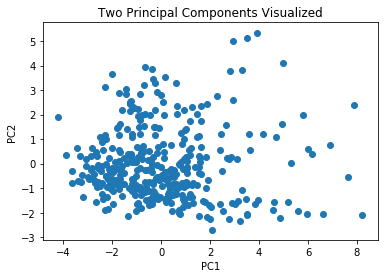

In [26]:
pca_vars = pd.DataFrame(fit, columns = ['PC1','PC2'])
plt.scatter(pca_vars['PC1'],pca_vars['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2');
plt.title('Two Principal Components Visualized')
plt.show()

## Why Two principal components?

How do I know if the PCA analysis is a good representation of the data? I just picked the first two principal components because 2-dimensional graphs are easy to interpret. I'll do some additional analysis to see how much variance our first two principal components (and more components) capture in the data.

The Line graph below plots the "Explained Variance Ratio" as I add more principal components to the analysis. 

Two principal components explained variance ratio: 0.62


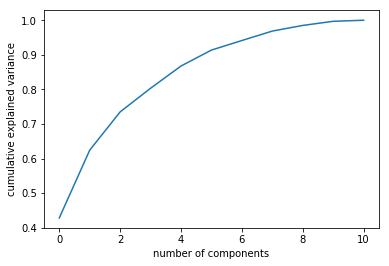

In [29]:
pca = PCA().fit(standardized_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print("Two principal components explained variance ratio:", round(sum(pca.explained_variance_ratio_[0:2]),2))

**Interpreting the Explained Variance Ratio**

The plot above shows that after seven to eight principal components are used, the additional variance captured is minimal. My ininital choice of two principal components accounts for about 62% of the variance in the dataset- This isn't as high as I'd like it to be. I would prefer at least 85%, which doesn't happen till the fifth principal component is added. For plotting purposes, the two components are easy to see, but moving forward in the analysis, I'll use five components. The next step will be running the k-means algorithm on the data, using the principal components of the dataset that I just came up with.

In [33]:
print("Five principal components explained variance ratio:", round(sum(pca.explained_variance_ratio_[0:5]),2))

Five principal components explained variance ratio: 0.87


## The K-Means Clustering Algorithm
K-means is one of the simplest unsupervised learning algorithms to solve clustering problems. K-means is an unsupervised algorithm because we don't have any labels for the points (for example: position, all-star, all-nba team). We're simply plugging in the data points, and letting k-means determine the labels. The only thing we actually choose is the number of clusters we want to segment the data into. Intuitively, each cluster should reflect some sort of similar grouping. My objective is to segment players into buckets of talent and style of play. I purposely left out position in the variables. If I were to add position, I would likely only add in indicators of "Guard" and "Big", given the current state of the talent and style of play in today's NBA.

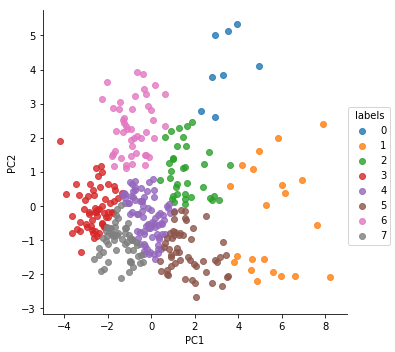

In [34]:
%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

centroids = kmeans2(pca_vars, k = 8)[0]
labels = kmeans2(pca_vars, k = 8)[1]

        
pca_vars['labels'] = labels
sns.lmplot(x = 'PC1', y = 'PC2', data = pca_vars,hue ='labels', fit_reg= False)

**K-means results**

Again, just like the two principal components, I arbitrarily chose five clusters for the algorithm to compute. I chose this based on my knowledge of the game, and more specifically, the NBA. I'm guessing that there are about 6-8 "levels" of players in the NBA. There's a top tier of talent of about 20 players in the NBA (5 or 6 that are elite every year), and after that, talent kind of drops off in steps. The rest of the players after the top two tiers sort of fit into roles based on the team that they are on. I want my k-means algorithm to capture the top 2-3 tiers really well.

I can't really extract any meaningful information from the graph above. It's a simple scatter plot using the two principal components from earlier- and it also includes our clusters on the color palette. I'll add the cluster labels from the k-means algorithm to the initial dataset, so I can map some labels to actual player names. One pitfall of PCA is that the actual values of the PCA components are going to mean very little, becasue I don't truly know what exactly they represent. Nevertheless, I'll take a look at the first 20 players and their cluster labels.

In [35]:
player_labels = pca_vars.copy()
player_labels['Player'] = df3['Player']
player_labels.head(20)

,PC1,PC2,labels,Player
0,8.221335,-2.094065,1,James Harden
1,7.629042,-0.557029,1,LeBron James
2,5.811423,1.982387,1,Karl-Anthony Towns
3,7.892005,2.393011,1,Anthony Davis
4,5.603357,-1.938435,1,Damian Lillard
5,6.906251,0.741555,1,Giannis Antetokounmpo
6,4.691344,1.075744,1,LaMarcus Aldridge
7,5.287492,0.009508,1,Nikola Jokic
8,6.165336,0.381547,1,Kevin Durant
9,4.969981,4.100937,0,Andre Drummond


## K-means Results and Tableau Link

Looking at just a subset of the data (the intial data was sorted by PER), I can see that most of the first 20 players were labeled the same (1). I'm going to guess that our "1" group is our top-tier talent. One other note is that the players not in the "1" group, in my opinion, look like they would be second-tier players, so that makes some sense at first glance. Additionally, the non-ones are almost all (besides Lowry) bigs.

For comparison purposes I'm going to run the k-means algorithm on the initial 11 variables as well (without the PCA analysis). In the end, I'll likely select the one that in my opinion subsets the players more effectively. 

The rest of my analysis (the fun part) will be completed in tableau. It'll be much easier and more interactive to vizualize this data with some of the features tableau offers.

The remaining code cells join the cluster labels with the stats and then extract the dataset to a csv file (for both the PCA algorithm and full dataset algotithm).

Tableau Link:https://public.tableau.com/views/NBAPlayerClusterAnalysis/ClusterDistributionsbyTeam?:embed=y&:display_count=yes

Twitter profile: @Spelk24

LinkedIn: www.linkedin.com/in/spelkofer/


In [39]:
#PCA Dataset
Cluster1 = player_labels.merge(advanced2, on = 'Player',how = 'left')
PCA_Algorithm = Cluster1.merge(pergame_stats,on = 'Player', how = 'left')
PCA_Algorithm.head(5)

,PC1,PC2,labels,Player,Pos_x,Age_x,Tm_x,G_x,MP_x,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,8.221335,-2.094065,1,James Harden,SG,28,HOU,72,2551,29.8,...,0.858,0.6,4.8,5.4,8.8,1.8,0.7,4.4,2.3,30.4
1,7.629042,-0.557029,1,LeBron James,PF,33,CLE,82,3026,28.6,...,0.731,1.2,7.5,8.6,9.1,1.4,0.9,4.2,1.7,27.5
2,5.811423,1.982387,1,Karl-Anthony Towns,C,22,MIN,82,2918,24.9,...,0.858,2.9,9.4,12.3,2.4,0.8,1.4,1.9,3.5,21.3
3,7.892005,2.393011,1,Anthony Davis,PF,24,NOP,75,2727,28.9,...,0.828,2.5,8.6,11.1,2.3,1.5,2.6,2.2,2.1,28.1
4,5.603357,-1.938435,1,Damian Lillard,PG,27,POR,73,2670,25.2,...,0.916,0.8,3.6,4.5,6.6,1.1,0.4,2.8,1.6,26.9


In [40]:
path2 = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\pca_output.csv'

In [41]:
#Extract the File
PCA_Algorithm.to_csv(path2, index = False)

In [42]:
#Performing kmeans on the entire dataset
df5 = df4.copy()
centroids = kmeans2(df5, k = 8)[0]
labels = kmeans2(df5, k = 8)[1]

In [49]:
df5['Player'] = df3['Player']
df5['Clusters'] = labels
Clusters3 = df5.copy()

In [50]:
AllData_kmeans = Clusters3.merge(pergame_stats, on = 'Player',how = 'left')

In [52]:
#Extract the File
path2 = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\K-Means Clustering on NBA Players\all_data_output2.csv'
AllData_kmeans.to_csv(path2, index = False)